In [1]:
import json
with open('./training_data/final_dataset.json') as json_file:
        loaded_dict = json.load(json_file)

In [2]:
X_train = loaded_dict["X_train"]
X_test = loaded_dict["X_test"]
Y_train = loaded_dict["Y_train"]
Y_test = loaded_dict["Y_test"]

In [3]:
len(X_train), len(X_test)

(7983, 2485)

# Training process
## Here is implemented a custom PyTorch training loop that includes logging and saving the best model

In [4]:
import torch
from tqdm.auto import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom dataset class
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
model.to(device)


max_len = 150
train_dataset = IntentDataset(X_train, Y_train, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_loader))

# Define dataset and dataloader for validation
val_dataset = IntentDataset(X_test, Y_test, tokenizer, max_len)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(len(val_loader))

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


250
78


In [5]:
# File for logging
with open('./logs.csv', 'w') as file:
    file.write('epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy\n')

In [6]:
best_accuracy = 0.0 
best_eval_accuracy = 0.0

epochs = 10

# adding this as the model already at 99% after 1st epoch
loss_first_epoch = []
acc_first_epoch = []

for epoch in tqdm(range(epochs)):
    running_loss = 0.0 
    running_acc = 0.0
    
    running_eval_loss = 0.0 
    running_eval_acc = 0.0

    model.train()
    # Training
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        accuracy = torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
        running_acc += accuracy

        if epoch==0:
            loss_first_epoch.append(loss.item())
            acc_first_epoch.append(accuracy)
            
        
    epoch_accuracy = running_acc / len(train_loader.dataset)
    epoch_loss = running_loss / len(train_loader)

    if epoch_accuracy > best_accuracy: # выбираем лучшую точность
            best_accuracy = epoch_accuracy
    
    # Validation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            accuracy = torch.sum(torch.argmax(outputs.logits, dim=1) == labels)

            running_eval_loss += loss
            running_eval_acc += accuracy
    
    
    epoch_val_loss = running_eval_loss / len(val_loader)
    epoch_val_accuracy = running_eval_acc / len(val_loader.dataset)     

    if epoch_val_accuracy>= best_eval_accuracy:
        best_eval_accuracy = epoch_val_accuracy
        model.save_pretrained('./best_trained_model/')
        tokenizer.save_pretrained('./best_trained_model/')

    print(f'EPOCH {epoch+1}: Loss: {epoch_loss}, Accuracy: {epoch_accuracy}, Best_accuracy: {best_accuracy}')
    print(f'Val_loss: {epoch_val_loss}, Val_accuracy: {epoch_val_accuracy}, Best_val_accuracy: {best_eval_accuracy}')
    print()
        
    with open('./logs.csv', 'a') as file:
        file.write(f'{epoch+1},{epoch_loss},{epoch_accuracy},{best_accuracy},{epoch_val_loss},{epoch_val_accuracy},{best_eval_accuracy}\n')


model.save_pretrained('./last_trained_model/')
tokenizer.save_pretrained('./last_trained_model/')


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1: Loss: 0.07531508708419278, Accuracy: 0.9754478335380554, Best_accuracy: 0.9754478335380554
Val_loss: 0.0372481606900692, Val_accuracy: 0.9915492534637451, Best_val_accuracy: 0.9915492534637451

EPOCH 2: Loss: 0.025479779415763914, Accuracy: 0.9929850697517395, Best_accuracy: 0.9929850697517395
Val_loss: 0.01622132398188114, Val_accuracy: 0.9983903169631958, Best_val_accuracy: 0.9983903169631958

EPOCH 3: Loss: 0.007829141274210997, Accuracy: 0.9984967708587646, Best_accuracy: 0.9984967708587646
Val_loss: 0.024678191170096397, Val_accuracy: 0.9943661689758301, Best_val_accuracy: 0.9983903169631958

EPOCH 4: Loss: 0.007586003143747803, Accuracy: 0.9979957342147827, Best_accuracy: 0.9984967708587646
Val_loss: 0.01661650836467743, Val_accuracy: 0.9967806339263916, Best_val_accuracy: 0.9983903169631958

EPOCH 5: Loss: 0.010591504863463342, Accuracy: 0.9982462525367737, Best_accuracy: 0.9984967708587646
Val_loss: 0.026390550658106804, Val_accuracy: 0.9955734014511108, Best_val_accur

('./last_trained_model/tokenizer_config.json',
 './last_trained_model/special_tokens_map.json',
 './last_trained_model/vocab.json',
 './last_trained_model/merges.txt',
 './last_trained_model/added_tokens.json')

# Metrics

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./logs.csv')
df

,epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy
0,1,0.075315,0.975448,0.975448,0.037248,0.991549,0.991549
1,2,0.025480,0.992985,0.992985,0.016221,0.998390,0.998390
2,3,0.007829,0.998497,0.998497,0.024678,0.994366,0.998390
3,4,0.007586,0.997996,0.998497,0.016617,0.996781,0.998390
4,5,0.010592,0.998246,0.998497,0.026391,0.995573,0.998390
5,6,0.012606,0.997244,0.998497,0.019656,0.995976,0.998390
6,7,0.011253,0.997495,0.998497,0.028631,0.993561,0.998390
7,8,0.013197,0.997495,0.998497,0.024980,0.995171,0.998390
8,9,0.012581,0.997369,0.998497,0.025658,0.995573,0.998390
9,10,0.013560,0.997119,0.998497,0.046121,0.990744,0.998390


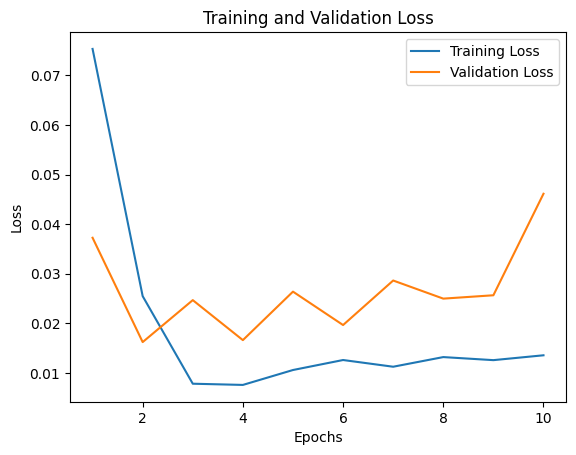

In [8]:
plt.plot(df.epoch, df.loss, label='Training Loss')
plt.plot(df.epoch, df.val_loss, label='Validation Loss')
 

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

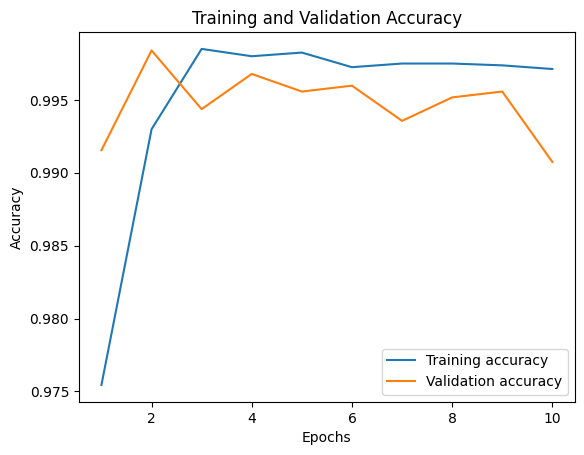

In [9]:
plt.plot(df.epoch, df.accuracy, label='Training accuracy')
plt.plot(df.epoch, df.val_accuracy, label='Validation accuracy')
 
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

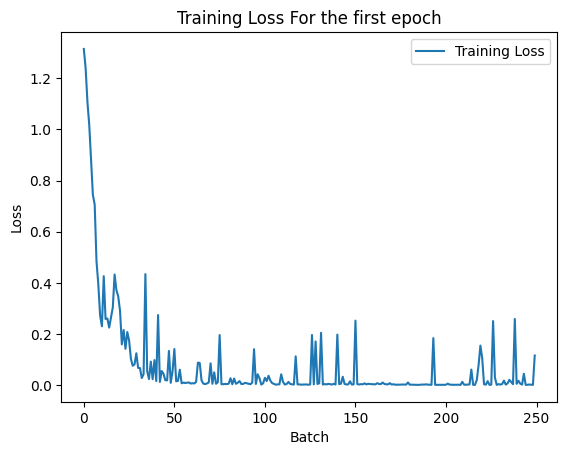

In [10]:
plt.plot(list(range(len(loss_first_epoch))), loss_first_epoch, label='Training Loss')

plt.title('Training Loss For the first epoch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

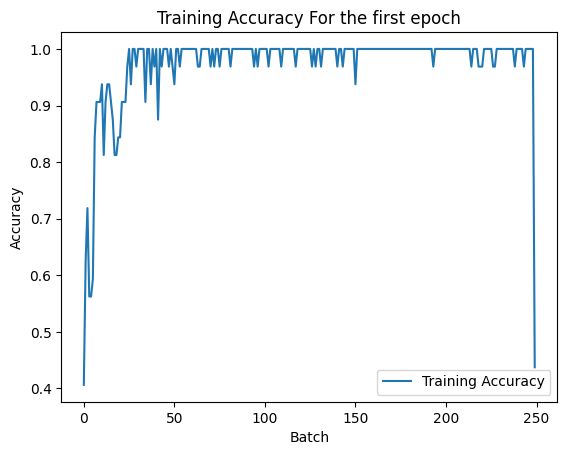

In [11]:
plt.plot(list(range(len(acc_first_epoch))), [i.cpu()/32 for i in acc_first_epoch], label='Training Accuracy')

plt.title('Training Accuracy For the first epoch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
from sklearn.metrics import classification_report

# load best model
model_path = './best_trained_model/'

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path).to(device)




# Initialize lists to store predictions and ground truth labels
predicted_labels = []
true_labels = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    for batch in val_loader:  # Iterate through the validation dataset
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)  # Get the predicted labels

        # Convert tensors to numpy arrays and store in lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       632
           1       1.00      1.00      1.00      1454
           2       1.00      0.99      1.00       213
           3       1.00      0.99      1.00       186

    accuracy                           1.00      2485
   macro avg       1.00      1.00      1.00      2485
weighted avg       1.00      1.00      1.00      2485



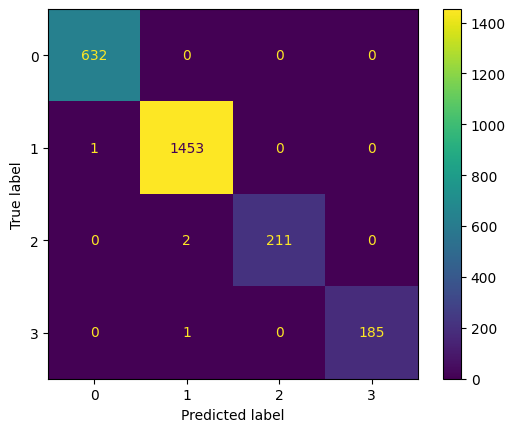

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# рассчитывает confusion matrix
cm = confusion_matrix(y_true=true_labels,y_pred=predicted_labels)


# рисуем её
plt.Figure()
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Inference

In [14]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

model_path = './best_trained_model/'

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)


In [15]:
input_text1 = "hey, oliver thompson here. considering a flight from moscow to singapore on july 5th, 2024. seen any flights around that time?"
input_text2 = "How are you?"
input_text3 = "Thank you for help!"
input_text4 = "Good bye!"

data = [input_text1, input_text2, input_text3, input_text4]

for input_text in data: 
    inputs = tokenizer(input_text, return_tensors='pt')
    
    # inference using the model
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
    
    # class to intent
    intents = {
        0: "search a flight details",
        1: "miscellaneous",
        2: "intent to thank",
        3: "intent to end conversation"
    }
    
    predicted_intent = intents[predicted_class]
    print(f"Predicted Intent: {predicted_intent}")


Predicted Intent: search a flight details
Predicted Intent: miscellaneous
Predicted Intent: intent to thank
Predicted Intent: intent to end conversation
